# Automated real estate evaluator

## Assignment understanding

The real estate market is a complex and dynamic environment; however, property prices are still influenced by a set of objective parameters. Different characteristics of a real estate property have varying impacts on both the quality of life for its inhabitants and the resulting market price. By employing machine learning models, we can identify the respective weight of each parameter, thereby making market navigation and understanding easier for buyers, sellers, and investors.

The goal of this assignment is to develop and evaluate two distinct models:
- A **linear regression model** to predict the continuous *"house price of unit area."*
- A **logistic regression model** to classify whether the house price is above or below the average price within the training data.

By constructing these models, we aim to deepen our understanding of regression logic and further practice the application of the CRISP-DM methodology.

## Data understanding

To build our models, we are using the [Real Estate Valuation Data Set](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set) from the UCI Machine Learning Repository. This dataset contains 414 instances (*websites*), each described by 6 features (*extracted from the website's URL and source code*) and a House pricing as target variable.

**Target variable** is measured in tens of thousands of Taiwan dollar per Ping and represented as decimal number.

If Y is 10 it will be 10000 TWD = approx to 242 EUR [in 2013](https://twd.fxexchangerate.com/eur-2013_12_27-exchange-rates-history.html), Where [Ping](https://en.wikipedia.org/wiki/Pyeong) is Asian unit of aria equals approx. to 3,3 sqr meter

**Features** represented as numerical values in different units:

| Feature Name                               | Description | Unit |
|--------------------------------------------| --- | --- |
| **X1 transaction date**                    | The date of the transaction (e.g., 2013.250 for March 2013) | Year (fractional) |
| **X2 house age**                           | The age of the house | Years |
| **X3 distance to the nearest MTR station** | The distance to the nearest Mass Rapid Transit station | Meters |
| **X4 number of convenience stores**        | The number of convenience stores within walking distance | Integer |
| **X5 latitude**                            | The geographic coordinate, latitude | Degrees |
| **X6 longitude**                           | The geographic coordinate, longitude | Degrees |


## Data preparation

The process begins with loading the dataset directly from the UCI ML Repository. This is accomplished by using the `ucimlrepo` library, which provides convenient and reproducible access to the data by referencing its unique ID.

In [165]:
# all necessary imports
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report

# Fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# Data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

# Combine features and target for easier exploration
df = pd.concat([X, y], axis=1)

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the dataset: ---\n")
display(df.head(5))


# Display the all relevant info
print("\n--- Summary table ---\n")
summary_table = df.describe().T
summary_table['value_type'] = df.dtypes
summary_table['missing'] = df.isnull().sum()
display(summary_table)




--- First 5 rows of the dataset: ---



,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1



--- Summary table ---



,count,mean,std,min,25%,50%,75%,max,value_type,missing
X1 transaction date,414.0,2013.148971,0.281967,2012.66700,2012.917000,2013.16700,2013.417000,2013.58300,float64,0
X2 house age,414.0,17.712560,11.392485,0.00000,9.025000,16.10000,28.150000,43.80000,float64,0
X3 distance to the nearest MRT station,414.0,1083.885689,1262.109595,23.38284,289.324800,492.23130,1454.279000,6488.02100,float64,0
X4 number of convenience stores,414.0,4.094203,2.945562,0.00000,1.000000,4.00000,6.000000,10.00000,int64,0
X5 latitude,414.0,24.969030,0.012410,24.93207,24.963000,24.97110,24.977455,25.01459,float64,0
X6 longitude,414.0,121.533361,0.015347,121.47353,121.528085,121.53863,121.543305,121.56627,float64,0
Y house price of unit area,414.0,37.980193,13.606488,7.60000,27.700000,38.45000,46.600000,117.50000,float64,0


From the initial analysis, we can see that data types are appropriate for each column and no missing values were found. Therefore, can safely split the data into two sets and standardize the features.

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Useful variable
randomstate = 123

# Do the 70/30 data split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate)

# Do the standardization
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Visualization
print("\n--- First 5 rows of the scaled training data: ---\n")

# Convert the scaled arrays back to pandas DataFrames for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
display(X_train_scaled.head(5))

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


--- First 5 rows of the scaled training data: ---



,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
246,0.950982,-0.090643,-0.543453,0.674242,-0.454699,0.613246
342,-1.719796,-1.012062,-0.776334,1.703411,0.374279,0.637070
157,0.356289,-0.116477,-0.211978,-0.011870,0.742082,0.092326
232,-0.829537,0.830776,2.586040,-1.041039,-1.575159,-2.404098
12,-0.829537,-0.383430,-0.463788,0.331186,-0.371071,0.268112


Training set size: 289 samples
Testing set size: 125 samples


## Modeling - Linear regression

First, we will build a linear regression model to predict the continuous target variable Y house price of unit area.

In [167]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Feature importance

After a model is trained, it is possible to analyze its components to understand which features most significantly influence its predictions. In linear regression, this is achieved by examining the model's coefficients and its intercept.

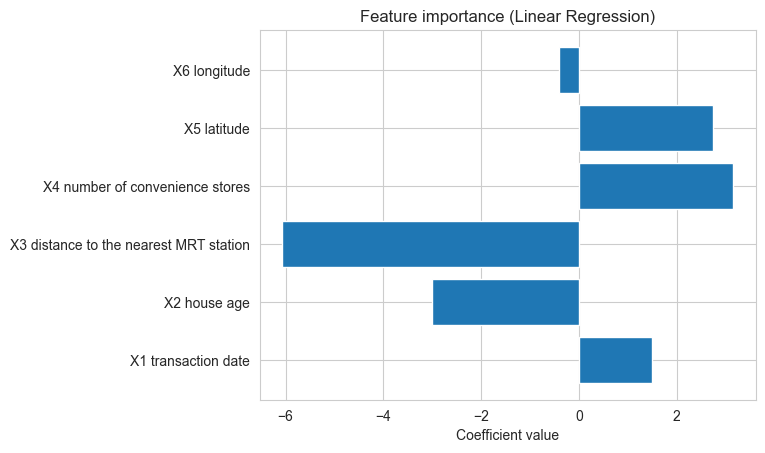

Intercept: [38.20346021]


In [168]:
# Muutetaan koeffisientit 1D-taulukoksi
coefs = linreg.coef_[0]
features = X.columns

# Values weight plot
plt.barh(features, coefs)
plt.xlabel("Coefficient value")
plt.title("Feature importance (Linear Regression)")
plt.show()
print(f"Intercept: {linreg.intercept_}")

The plot above reveals that the **distance to the nearest MRT station (X3)** outweighs all other features by a large margin, with a coefficient of nearly -6. This feature has a strong inverse relationship with the result: as the distance from a station increases, the property price decreases significantly. A similar, though less pronounced, inverse relationship is observed for **house age (X2)**, where an increase in age negatively affects quality of living and price with it.

On the "positive" side, the **number of convenience stores (X4)** has a strong positive impact, which is intuitively understandable. Interestingly, **transaction date (X1)** and **latitude (X5)** also have a significant positive influence. Our data spans a two-year period, which may seem short. However, the model assigns the transaction date a coefficient of 1.8. This is supported by external statistics ([Source 1](https://www.tradingview.com/symbols/ECONOMICS-TWHPI/chart/?timeframe=ALL) & [Source 2](https://www.globalpropertyguide.com/asia/taiwan/home-price-trends)). According to housing market index data, real estate in Taiwan experienced significant growth between 2012 and 2013. The index increased from 84.3 points in 2012 to 105 points in the end of 2013, representing an approximate growth rate of 24.5%. While not the most dominant feature, its impact is still impressive.

It is less immediately obvious why latitude would affect the price at a similar rate to the number of stores. However, an examination of a map of the area  [google maps](https://www.google.com/maps/place/Xindian+District,+New+Taipei+City,+Taiwan+231/@24.9284577,121.4927707,13z/data=!3m1!4b1!4m6!3m5!1s0x346803de337f4fe1:0xe29baf27fbf0968f!8m2!3d24.978282!4d121.5394822!16zL20vMDNzcmN0?hl=en&entry=ttu&g_ep=EgoyMDI1MDkxNi4wIKXMDSoASAFQAw%3D%3D) reveals that the dataset covers the Xindian District of New Taipei City. In this context, increasing the latitude corresponds to moving north, towards the city center, where property values are generally higher.

![Map Image of Xindian District](.\Attachments\img.png)



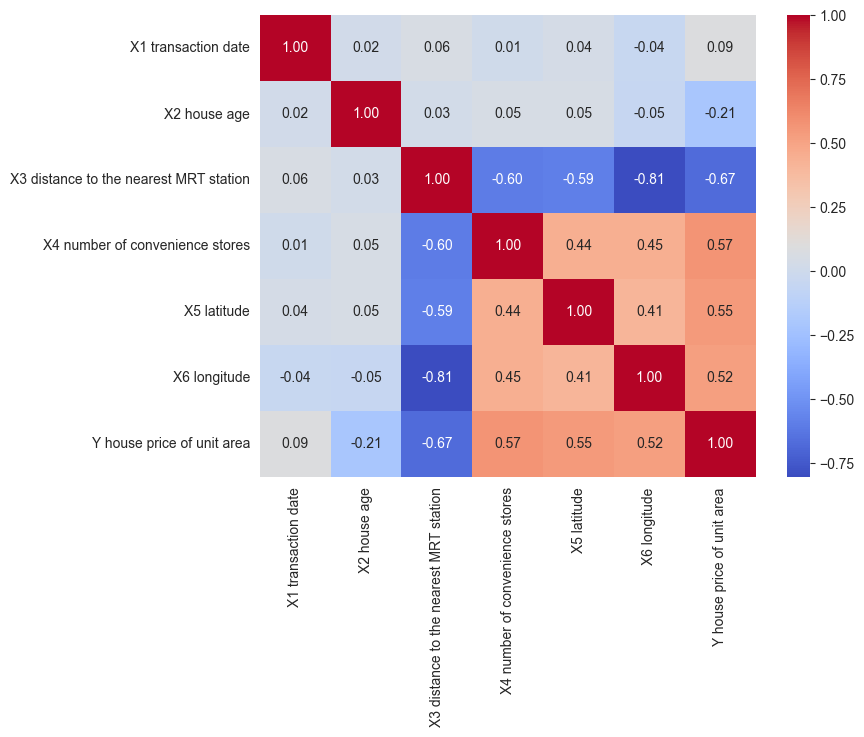

In [169]:
import seaborn as sns
import pandas as pd

# Yhdistetään piirteet ja target yhdeksi DataFrameksi
df_corr = pd.concat([X, y], axis=1)

# Lasketaan korrelaatiomatriisi
corr_matrix = df_corr.corr()

# Piirretään heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.show()

These findings are further substantiated by the correlation matrix: The matrix confirms that both **latitude** and **longitude** are positively correlated with the house price, as is the **number of convenience stores**. Conversely, the **distance to the nearest MRT station** shows a strong negative correlation with the price.

This pattern of correlations suggests the basic principles of urban real estate in a high-density area. Key amenities and higher property values are concentrated around logistical hubs, such as metro stations. As one moves away from these central points, the property values tend to decrease, illustrating the premium placed on accessibility and convenience.

## Evaluation - Linear regression

To evaluate the performance of our linear regression model, we used a combination of quantitative metrics and graphical analysis on the test set. The graphical evaluation is approached in two distinct patterns:

- **Direct Comparison of Predicted vs. Actual Values**: This is accomplished with a scatter plot that maps the actual values against the values predicted by our model. In a well-performing model, the data points should align closely with a 45-degree diagonal line, which represents a perfect prediction.

- **Analysis of Residuals**: This method involves subtracting the predicted values from the actual values to calculate the model's errors, or residuals. An ideal residual plot should show a random scatter of points around the zero line, with no discernible patterns.

### Actual vs Predicted Values

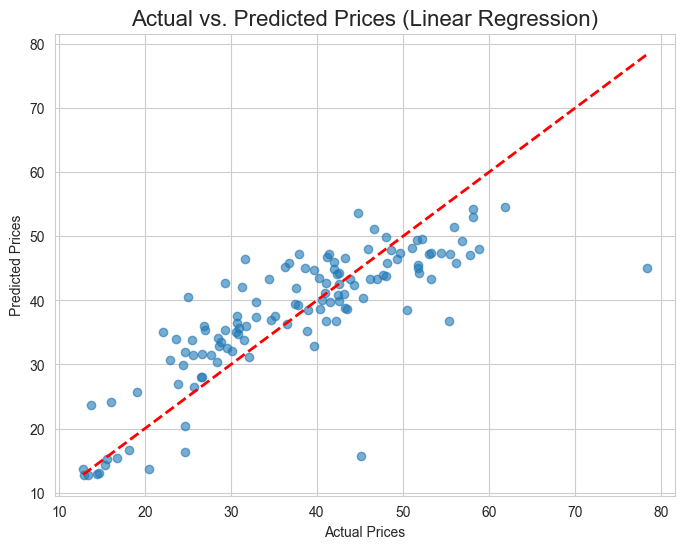

Mean Squared Error (MSE): 52.32
Root Mean Squared Error (RMSE): 7.23
Mean Absolute Error (MAE): 5.346
R-squared (R2) Score: 0.67


In [170]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = linreg.predict(X_test_scaled)

# Visualize the predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices (Linear Regression)", size=16)
plt.show()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.2f}")

The scatter plot of Actual vs. Predicted Prices provides a direct visual insight into the model's performance. The data points generally align with the diagonal red line, which represents a reasonably good fit with only a few noticeable outliers. This alignment indicates that the model has <del>somehow</del> effectively learned the underlying trend in the data.

The primary metric, the R-squared score, was 0.67. According to the AI: *This indicates that our model successfully explains approximately 67% of the variance in the "house price of unit area." This is a moderately strong result, suggesting that the selected features have significant predictive power.* But it still just over half the way to the perfect 1.0 result, so it is hard to understand will this be enough in the real world scenario.

To better understand the magnitude of the prediction error in practical terms, we analyzed both the Root Mean Squared Error (RMSE) and the Mean Absolute Error (MAE). The MAE, which was 5.346 in our tests, gives the average error magnitude. In contrast, the RMSE was higher at 7.23. We chose to focus on RMSE as it is a stricter metric; due to the fact that it is derived from the Mean Squared Error (MSE). Therefore, it penalizes large errors (*or outliers*) much more heavily than MAE. For MAE, an error of 10 is treated as exactly twice as bad as an error of 5, whereas for RMSE, the penalty is squared.

### Residual plot

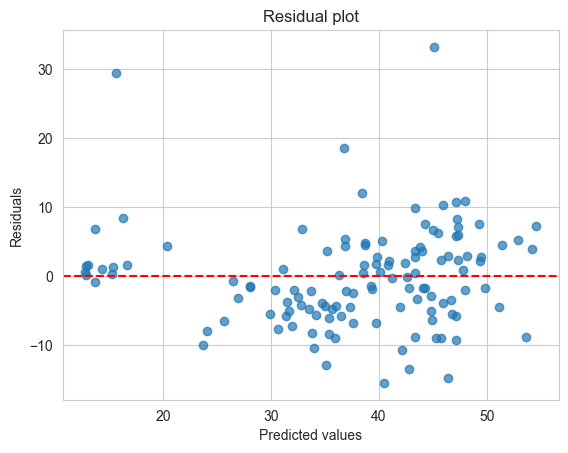

In [171]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual plot")
plt.show()


Our residual plot displays a healthy, random scatter of points centered around the horizontal line at zero. The vertical spread of the points is roughly consistent across the range of predicted values. There is no obvious curve, U-shape or cone shape, which suggests the linearity assumption of our model is met. The few significant outliers, previously noted in the Actual vs. Predicted plot, are clearly visible here as points far from the zero line.

Points are concentrated on the right side of the plot. It might be reflection of the distribution of the data in our test set. The horizontal axis represents the predicted house prices, and the plot shows that most of the predicted prices fall between approximately 30 and 50. This is expected, as this is the most common price range in the dataset.

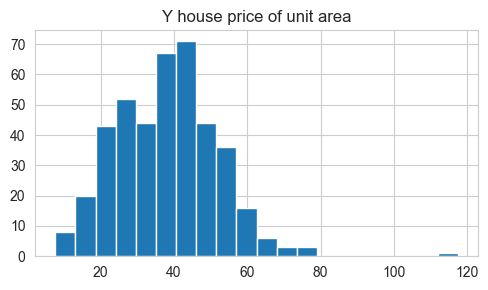

In [172]:
# Plot histograms for prices
y.hist(bins=20, figsize=(5, 3))
plt.tight_layout()
plt.show()

## Modeling - Logistic regression

In [173]:
# changing y from table to the list
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# get the mean price in the training set
mean_price = y_train.mean()
print(f"Average house price in the training set: {mean_price:.2f}")

# convert the target variable into binary
y_train_bin = (y_train > mean_price).astype(int)
y_test_bin  = (y_test > mean_price).astype(int)

Average house price in the training set: 38.20


In [174]:
from sklearn.linear_model import LogisticRegression

# build and fit model
logreg = LogisticRegression(random_state=randomstate)
logreg.fit(X_train_scaled, y_train_bin)

# print coefficients and intercept
print("Intercept: ", logreg.intercept_)
print("Coefficients: ", logreg.coef_)

Intercept:  [-0.79552376]
Coefficients:  [[ 0.32201035 -0.72420697 -2.41508945  0.60045634  0.99249246  0.23871542]]


#### Feature importance

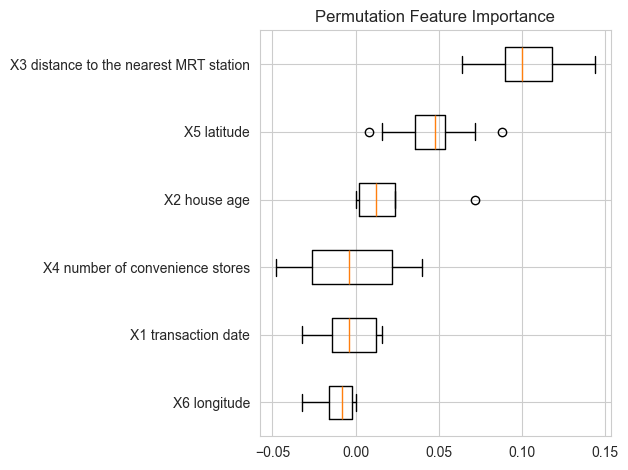

In [175]:
from sklearn.inspection import permutation_importance

result = permutation_importance(logreg, X_test_scaled, y_test_bin, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)

# sort features by importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Feature Importance")
fig.tight_layout()
plt.show()

The plot shows that the higher the value for each feature is, the more important it is. For example, the distance to the nearest metro station would be considered of the highest importance.

## Evaluation - Logistic regression

Accuracy: 0.82
Confusion Matrix:
 [[46 15]
 [ 8 56]]


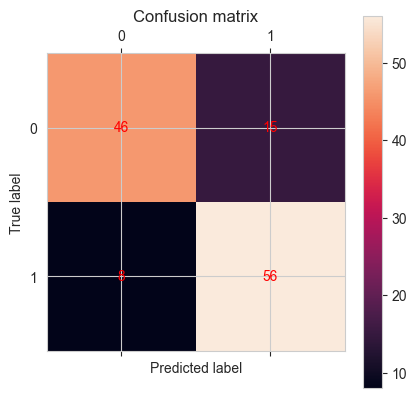

In [176]:
# cross-validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(estimator = logreg, X = X_test_scaled, y = y_test_bin, cv = 10)

cm = confusion_matrix(y_test_bin, y_pred)
accuracy = accuracy_score(y_test_bin, y_pred)

print("Accuracy: %0.2f" % accuracy)
print("Confusion Matrix:\n", cm)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.show()

### Interactive prediction

As a bonus, the following script allows for an interactive prediction. It is possible to input custom data for an example house to see how the logistic regression model would classify it.

In [177]:
# features = X.columns.tolist()  # use your actual feature names
#
# # create empty DataFrame to hold input
# Xi = pd.DataFrame(columns=features)
#
# # read input data
# for f in features:
#     val = input(f"Enter value for feature '{f}': ")
#     Xi[f] = [float(val)]
#
# # scale the input
# Xi_scaled = pd.DataFrame(scaler.transform(Xi), columns=Xi.columns)
#
# # get probability estimate of class 1 (above-average price)
# p = logreg.predict_proba(Xi_scaled)[:, 1]
#
# # output
# print("Probability that house price per unit is above average: %0.2f" % p[0])

While this is an interesting feature for exploring the model's behavior, it has significant limitations for practical use. The model was trained on data from a specific time period (2012-2013), so baseline for an "average" price is outdated. Due to inflation and market trends, model would almost certainly classify it as being "above average," not because it is a luxury property, but because "*housing pricing is always rising*".

## Deployment

The models developed in this project can be deployed as part of a decision support system for real estate professionals or potential buyers. The linear regression model can provide a price estimate for a given property, while the logistic regression model can give a quick classification of whether a property is priced above or below the market average.

To deploy these models, one could create a simple web application where a user can input the features of a property and get the predicted price and classification.

### Reflection

#### Ai Usage
Large language model was used to help to structure the notebook, write the explanations, and debug the code. The model was particularly helpful in ensuring that the analysis followed the CRISP-DM framework and that the explanations were clear and concise.